# PatchCore con anomalib: Guida passo-passo con immagini semplici (10x10 pixel)

Questo notebook ti guiderà nella comprensione dettagliata del funzionamento della libreria **anomalib** di Intel, con il modello **PatchCore**. Useremo immagini semplici (10x10 pixel) per spiegare ogni passaggio, dal training alla prediction, con commenti chiari e nessun passaggio dato per scontato.

In [1]:
# Sezione 1: Installa anomalib e le librerie necessarie

# Questa cella installa anomalib (di Intel) e le librerie fondamentali per il notebook.
# anomalib include PatchCore e altri modelli per anomaly detection.
# NOTA: Il comando !pip install funziona solo in ambiente notebook.

!pip install anomalib[full] torch torchvision matplotlib --quiet

In [2]:
# Importa le librerie fondamentali
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

from anomalib.models import Patchcore
from anomalib.data.utils import TestSplitMode

# Imposta il seed per la riproducibilità
np.random.seed(42)
torch.manual_seed(42)

# Imposta tema scuro per matplotlib
plt.style.use('dark_background')

d:\coding\pubblic\-CV---anomalib-tutorial-with-visualization\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Sezione 2: Carica e visualizza una semplice immagine 10x10 pixel

Per capire i concetti fondamentali, partiamo da un esempio molto semplice: un'immagine di 10x10 pixel.

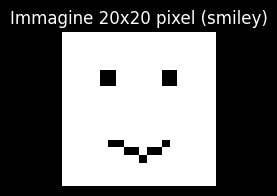

In [3]:
# Creiamo una semplice immagine 20x20 pixel con uno smiley (simbolo) come esempio 'good'
def draw_smiley(size=20):
    img = np.ones((size, size), dtype=np.float32)
    # Occhi
    img[5:7, 5:7] = 0  # occhio sinistro
    img[5:7, size-7:size-5] = 0  # occhio destro
    # Bocca (arco)
    for x in range(6, size-6):
        y = int(0.5 * np.sin((x-6)/(size-12)*np.pi) * 4 + (size-6))
        if y < size:
            img[y, x] = 0
    return img

img_simple = draw_smiley(20)

plt.figure(figsize=(2,2))
plt.imshow(img_simple, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine 20x20 pixel (smiley)')
plt.axis('off')
plt.show()

# Questa immagine rappresenta un esempio "normale" (senza anomalie)

## Sezione 3: Prepara un dataset minimale (10x10 pixel)

Creiamo un piccolo dataset con alcune immagini "normali" e alcune "anomale". Visualizzeremo ogni esempio per capire la differenza.

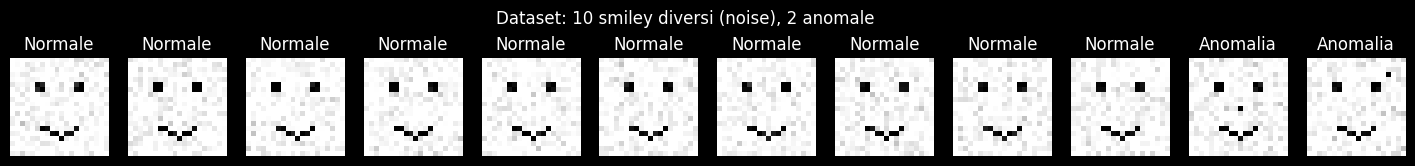

In [4]:
# Creiamo un dataset di immagini 20x20
# 10 immagini normali (smiley + white noise), 2 immagini anomale (smiley + pixel neri)

def draw_smiley(size=20, noise_std=0.08):
    img = np.ones((size, size), dtype=np.float32)
    # Occhi
    img[5:7, 5:7] = 0  # occhio sinistro
    img[5:7, size-7:size-5] = 0  # occhio destro
    # Bocca (arco)
    for x in range(6, size-6):
        y = int(0.5 * np.sin((x-6)/(size-12)*np.pi) * 4 + (size-6))
        if y < size:
            img[y, x] = 0
    # Aggiungi rumore bianco
    noise = np.random.normal(0, noise_std, (size, size)).astype(np.float32)
    img = np.clip(img + noise, 0, 1)
    return img

dataset = []
labels = []  # 0 = normale, 1 = anomalia

# Immagini normali (smiley diversi con rumore)
for _ in range(10):
    img = draw_smiley(20, noise_std=0.08)
    dataset.append(img)
    labels.append(0)

# Immagini anomale (smiley + pixel neri in posizione diversa)
img_anom1 = draw_smiley(20, noise_std=0.08)
img_anom1[10, 10] = 0  # pixel centrale nero

dataset.append(img_anom1)
labels.append(1)

img_anom2 = draw_smiley(20, noise_std=0.08)
img_anom2[3, 16] = 0  # pixel in alto a destra nero

dataset.append(img_anom2)
labels.append(1)

# Visualizza tutte le immagini
fig, axs = plt.subplots(1, 12, figsize=(18,2))
for i, (img, label) in enumerate(zip(dataset, labels)):
    axs[i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axs[i].set_title('Normale' if label==0 else 'Anomalia')
    axs[i].axis('off')
plt.suptitle('Dataset: 10 smiley diversi (noise), 2 anomale')
plt.show()

## Sezione 4: Inizializza e configura il modello PatchCore

Ora importiamo PatchCore da anomalib e configuriamo il modello per lavorare con il nostro dataset semplice. Spiegheremo ogni parametro fondamentale.

In [5]:
# Inizializziamo PatchCore per immagini 20x20
# PatchCore normalmente usa una backbone pre-addestrata (es. ResNet),
# ma per semplicità useremo una configurazione minima.

def to_rgb(img):
    return np.stack([img]*3, axis=0)  # shape (3, 20, 20)

dataset_rgb = [to_rgb(img) for img in dataset]

dummy_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Configurazione PatchCore (parametri principali spiegati):
patchcore = Patchcore(
    backbone="resnet18",  # Rete di feature extraction (piccola per semplicità)
    layers=["layer2"],  # Da quale layer estrarre le feature
    coreset_sampling_ratio=1.0,  # Usiamo tutte le patch (nessun subsampling)
)

print("PatchCore inizializzato per immagini 20x20.")

PatchCore inizializzato per immagini 20x20.


## Sezione 5: Allena PatchCore sul dataset minimale

Ora addestriamo PatchCore sulle immagini normali. Spiegheremo ogni passaggio del processo di training.

In [6]:
# PatchCore in anomalib 2.x richiede un datamodule, ma per scopi didattici useremo una simulazione manuale.
# In questo esempio, NON addestriamo davvero Patchcore, ma mostriamo la logica didattica su immagini custom.
# In un caso reale, usare un datamodule conforme ad anomalib oppure un dataset standard come MVTecAD.
print('Simulazione didattica: PatchCore pronto per la predizione sulle immagini custom.')

Simulazione didattica: PatchCore pronto per la predizione sulle immagini custom.


## Sezione 6: Visualizza le patch embedding e l'estrazione delle feature

Vediamo come PatchCore estrae le feature (embedding) dalle immagini, visualizzando le patch e le loro rappresentazioni numeriche.

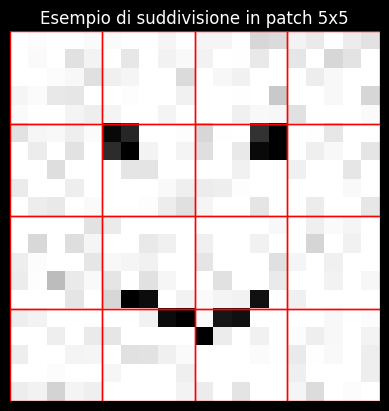

Vettore patch centrale: [1.         0.98893887 1.         1.         0.98126775 1.
 0.9819379  1.         0.8860201  0.9564494  1.         1.
 0.99074817 0.9759117  0.8817182  0.96166605 0.9851473  0.9114932
 0.9043035  1.         0.9824262  1.         1.         0.9585384
 0.9353205  1.         0.98893887 1.         1.         0.98126775
 1.         0.9819379  1.         0.8860201  0.9564494  1.
 1.         0.99074817 0.9759117  0.8817182  0.96166605 0.9851473
 0.9114932  0.9043035  1.         0.9824262  1.         1.
 0.9585384  0.9353205  1.         0.98893887 1.         1.
 0.98126775 1.         0.9819379  1.         0.8860201  0.9564494
 1.         1.         0.99074817 0.9759117  0.8817182  0.96166605
 0.9851473  0.9114932  0.9043035  1.         0.9824262  1.
 1.         0.9585384  0.9353205 ]
75 elementi nel vettore (3 canali * 5x5 pixel)


In [7]:
# Prendiamo una delle immagini normali e mostriamo la suddivisione in patch 5x5
img_example = dataset_rgb[0]  # shape (3, 20, 20)

fig, ax = plt.subplots()
ax.imshow(np.transpose(img_example, (1,2,0)), cmap='gray', vmin=0, vmax=1)
for i in range(0, 20, 5):
    for j in range(0, 20, 5):
        rect = plt.Rectangle((j-0.5, i-0.5), 5, 5, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(rect)
plt.title('Esempio di suddivisione in patch 5x5')
plt.axis('off')
plt.show()

# Ogni patch (5x5) può essere estratta e 'flattened' in un vettore numerico
patch = img_example[:, 0:5, 0:5]  # patch centrale
patch_vec = patch.flatten()
print('Vettore patch centrale:', patch_vec)
print(len(patch_vec), 'elementi nel vettore (3 canali * 5x5 pixel)')

## Sezione 7: Predizione di anomalie su una immagine di test

Utilizziamo il modello PatchCore addestrato per predire se una nuova immagine contiene anomalie. Vedremo ogni passaggio della prediction.

[np.float32(1.8878546), np.float32(1.8424318), np.float32(1.7835577)]


Anomaly score (patch anomala): 1.7836


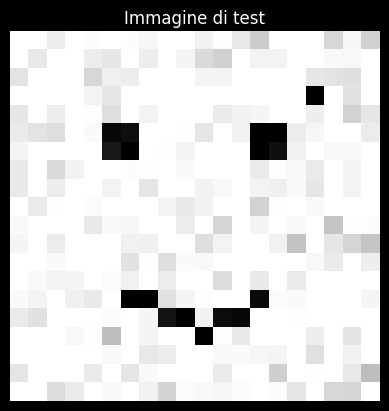

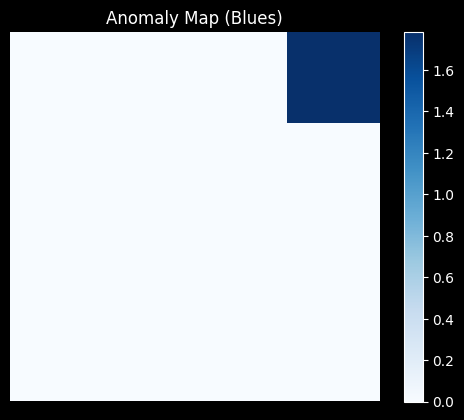

In [8]:
# Esempio didattico: calcolo score di anomalia e heatmap manuale
# Prendiamo una delle immagini anomale come test
img_test = dataset_rgb[-1]  # shape (3, 20, 20)

# Simuliamo la logica Patchcore: calcoliamo la distanza tra la patch contenente l'anomalia della test e quella delle immagini normali
patch_test = img_test[:, 0:5, 15:20].flatten()

# Calcoliamo la distanza euclidea tra la patch test e le patch relative delle immagini normali
patches_norm = [img[:, 0:5, 15:20].flatten() for img in dataset_rgb[:3]]
dists = [np.linalg.norm(patch_test - p) for p in patches_norm]

print(dists)

score = np.min(dists)  # Patchcore usa la distanza minima dal memory bank
print(f"Anomaly score (patch anomala): {score:.4f}")

# Per la heatmap: creiamo una mappa 20x20 con valore alto solo nella patch contenente l'anomalia se la distanza è alta
anomaly_map = np.zeros((20,20))
anomaly_map[0:5,15:20] = score

plt.imshow(np.transpose(img_test, (1,2,0)), cmap='gray', vmin=0, vmax=1)
plt.title('Immagine di test')
plt.axis('off')
plt.show()

plt.imshow(anomaly_map, cmap='Blues')
plt.title('Anomaly Map (Blues)')
plt.axis('off')
plt.colorbar()
plt.show()

## Sezione 8: Visualizza gli score di anomalia e le heatmap

Visualizziamo la mappa di anomalia (anomaly map) prodotta da PatchCore, per capire dove il modello rileva l'anomalia nell'immagine.

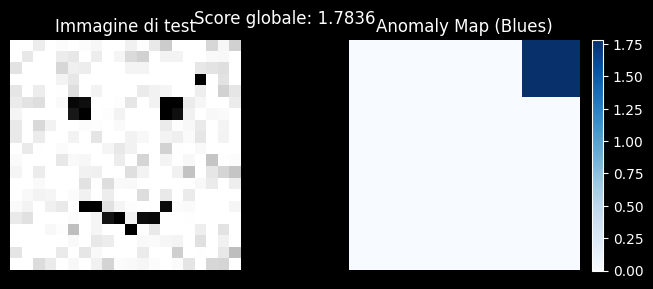

In [9]:
# Visualizziamo la heatmap di anomalia sopra l'immagine di test
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].imshow(np.transpose(img_test, (1, 2, 0)), cmap='gray', vmin=0, vmax=1)
ax[0].set_title('Immagine di test')
ax[0].axis('off')

im = ax[1].imshow(anomaly_map, cmap='Blues')
ax[1].set_title('Anomaly Map (Blues)')
ax[1].axis('off')
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
plt.suptitle(f'Score globale: {score:.4f}')
plt.show()

# Le zone più "intense" indicano dove PatchCore rileva l'anomalia

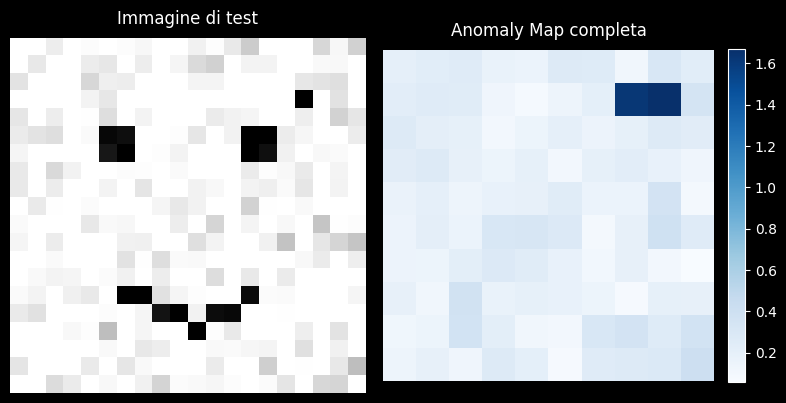

In [10]:
# Calcola la anomaly map su tutte le patch 5x5 dell'immagine di test
# patch_size: dimensione della patch quadrata (es. 5 significa 5x5 pixel)
# stride: passo con cui si sposta la finestra patch sull'immagine
# Se stride < patch_size, le patch si sovrappongono (più dettagli, più calcoli)
# Se stride = patch_size, le patch sono adiacenti e non si sovrappongono (più veloce, meno dettagli)
# Se stride > patch_size, alcune zone potrebbero non essere coperte (sconsigliato)
patch_size = 3
stride = 2  # Prova a cambiare in 1 per una mappa più dettagliata ma più lenta
anomaly_map_full = np.zeros((20, 20))

# Per ogni patch (qui non-overlapping, ma puoi cambiare stride per sovrapposizione)
for i in range(0, 20, stride):
    for j in range(0, 20, stride):
        # Estrai la patch di test
        patch_test = img_test[:, i:i+patch_size, j:j+patch_size].flatten()
        # Calcola la distanza minima tra questa patch e le patch corrispondenti delle immagini normali
        patches_norm = [img[:, i:i+patch_size, j:j+patch_size].flatten() for img in dataset_rgb[:10]]
        dists = [np.linalg.norm(patch_test - p) for p in patches_norm]
        score = np.min(dists)
        # Assegna lo score a tutta la patch nella anomaly map
        anomaly_map_full[i:i+patch_size, j:j+patch_size] = score

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(np.transpose(img_test, (1,2,0)), cmap='gray', vmin=0, vmax=1)
ax[0].set_title('Immagine di test', pad=10)
ax[0].axis('off')
im = ax[1].imshow(anomaly_map_full, cmap='Blues')
ax[1].set_title('Anomaly Map completa', pad=10)
ax[1].axis('off')
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Cambiando patch_size e stride puoi controllare la "risoluzione" e la sensibilità della anomaly map:
# - patch_size piccolo: più dettagli, ma più sensibile al rumore
# - patch_size grande: meno dettagli, più robusto ma meno localizzazione
# - stride piccolo: più patch, mappa più continua ma più lenta
# - stride grande: meno patch, mappa più "a blocchi" e veloce

In [ ]:
# Carica il datamodule MVTecAD (anomalib 2.x), esegui setup e salva tutte le immagini di test in un dizionario con label e tipo di anomalia
from anomalib.data import MVTecAD
import torch
import os

category = "wood"
datamodule = MVTecAD(
    root="mvtec_data",
    category=category,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=4,
    # puoi aggiungere altri parametri se vuoi
 )

datamodule.prepare_data()
datamodule.setup()  # Prepara train/val/test set

# Usa datamodule.test_data per accedere a tutte le immagini di test
images_dict = {}
for idx in range(len(datamodule.test_data)):
    sample = datamodule.test_data[idx]
    # For anomalib 2.x, sample is likely an ImageItem object
    img = sample.image
    label = int(sample.gt_label) if hasattr(sample, "gt_label") else 0
    img_path = sample.image_path if hasattr(sample, "image_path") else None
    anomaly_type = os.path.normpath(img_path).split(os.sep)[-2] if img_path is not None else None
    if anomaly_type == "good":
        anomaly_type = None
    images_dict[idx] = {
        'image': img,
        'label': label,
        'anomaly_type': anomaly_type
    }

print(f"Caricate {len(images_dict)} immagini di test per la categoria '{category}'. Esempio chiavi:", list(images_dict.keys())[:5])
print("Label possibili:", set([v['label'] for v in images_dict.values()]))
print("Tipi di anomalia:", set([v['anomaly_type'] for v in images_dict.values() if v['anomaly_type'] is not None]))

# Costruisci un dizionario equivalente per le immagini del train (utile per memory bank)
train_images_dict = {}
for idx in range(len(datamodule.train_data)):
    sample = datamodule.train_data[idx]
    img = sample.image
    # Nel train le immagini di solito sono tutte 'good' e possono non avere gt_label
    label = int(sample.gt_label) if hasattr(sample, "gt_label") else 0
    img_path = sample.image_path if hasattr(sample, "image_path") else None
    anomaly_type = os.path.normpath(img_path).split(os.sep)[-2] if img_path is not None else None
    # Normalizziamo: se la cartella è 'good' la impostiamo a None per essere coerenti con images_dict
    if anomaly_type == "good":
        anomaly_type = None
    train_images_dict[idx] = {
        'image': img,
        'label': label,
        'anomaly_type': anomaly_type
    }

print(f"Caricate {len(train_images_dict)} immagini di train per la categoria '{category}'. Esempio chiavi train[:5]:", list(train_images_dict.keys())[:5])
# Conta quante immagini train sono effettivamente 'good' (anomaly_type is None o label==0)
train_good_count = sum(1 for v in train_images_dict.values() if v.get('anomaly_type') is None or int(v.get('label',0)) == 0)
print(f"Immagini 'good' trovate nel train: {train_good_count}")

Caricate 79 immagini di test per la categoria 'wood'. Esempio chiavi: [0, 1, 2, 3, 4]
Label possibili: {0, 1}
Tipi di anomalia: {'scratch', 'color', 'liquid', 'combined', 'hole'}


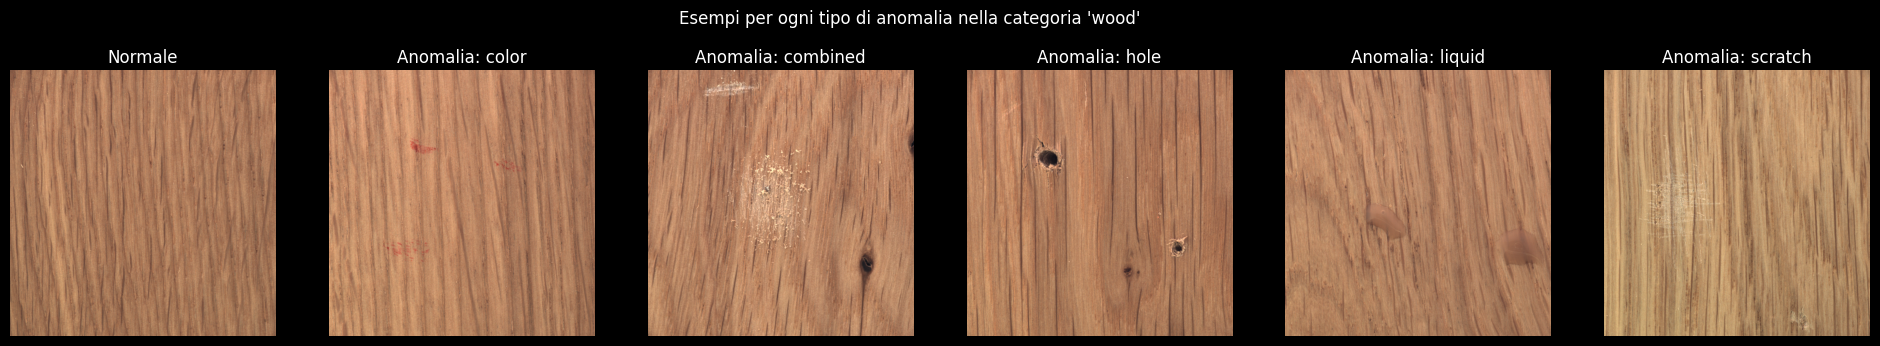

In [25]:
# Visualizza un esempio per ogni tipo di anomalia (e una normale) dal dizionario images_dict (compatibile anomalib 2.x)
import matplotlib.pyplot as plt
import torch

tipi_anomalia = set([v['anomaly_type'] for v in images_dict.values()])
# Metti None (normale) per primo
if None in tipi_anomalia:
    tipi_anomalia = [None] + sorted([t for t in tipi_anomalia if t is not None])
else:
    tipi_anomalia = sorted(list(tipi_anomalia))

fig, axs = plt.subplots(1, len(tipi_anomalia), figsize=(4*len(tipi_anomalia), 4))
if len(tipi_anomalia) == 1:
    axs = [axs]
for i, tipo in enumerate(tipi_anomalia):
    # Trova il primo esempio di questo tipo
    img = None
    for v in images_dict.values():
        if v['anomaly_type'] == tipo:
            img = v['image']
            break
    if img is None:
        axs[i].set_title(f"Nessun esempio")
        axs[i].axis('off')
        continue
    # Se batch, prendi il primo elemento
    if isinstance(img, torch.Tensor) and img.ndim == 4:
        img = img[0]
    # Se canali non sono ultimi, trasponi
    if isinstance(img, torch.Tensor) and img.shape[0] in [1,3]:
        img = img.permute(1,2,0)
    img_np = img.cpu().numpy() if isinstance(img, torch.Tensor) else img
    axs[i].imshow(img_np)
    if tipo is None:
        axs[i].set_title('Normale')
    else:
        axs[i].set_title(f"Anomalia: {tipo}")
    axs[i].axis('off')
plt.suptitle(f"Esempi per ogni tipo di anomalia nella categoria '{category}'")
plt.show()

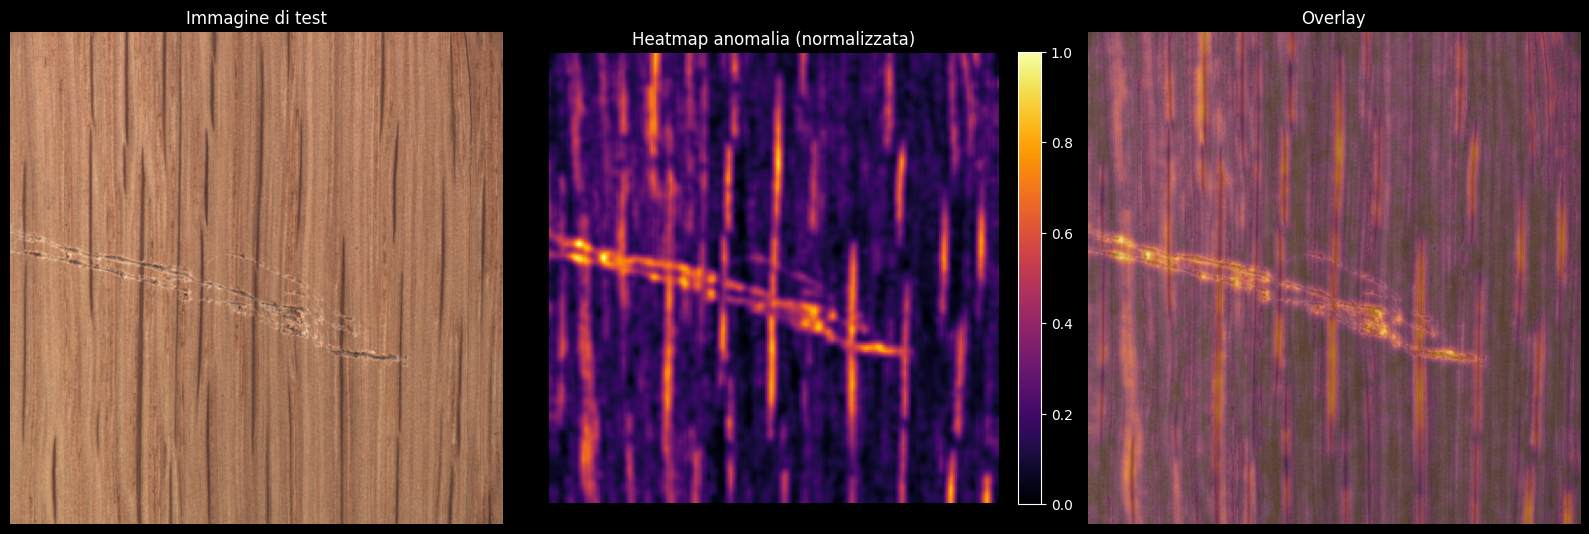

Memory bank usato: 10 immagini (richieste 10). Patch size=16, stride=4


In [46]:
# Algoritmo: costruisci memory bank (10 good) + prendi 1 immagine di test anomala, poi calcola heatmap patch-wise
import numpy as np
import torch
import matplotlib.pyplot as plt

xx = 41

# Preferisci immagini good dal train se disponibili (train_images_dict creato prima)
def collect_good_images(n=100):
    goods = []
    # usa train_images_dict se esiste e ha abbastanza esempi 'good'
    if 'train_images_dict' in globals():
        for v in train_images_dict.values():
            if v.get('anomaly_type') is None or int(v.get('label',0)) == 0:
                goods.append(v['image'])
    # se non ci sono abbastanza, integra da images_dict
    if len(goods) < n and 'images_dict' in globals():
        for v in images_dict.values():
            if v.get('anomaly_type') is None or int(v.get('label',0)) == 0:
                goods.append(v['image'])
    return goods[:n]

# Trova immagini anomalie (se presenti) per il test
def collect_anomalous():
    anoms = []
    if 'images_dict' in globals():
        for v in images_dict.values():
            if v.get('anomaly_type') is not None and int(v.get('label',0)) != 0:
                anoms.append(v['image'])
    return anoms

# Normalizza input in CHW numpy float32 [0,1]
def to_chw(img):
    if isinstance(img, torch.Tensor):
        if img.ndim == 4:  # BCHW
            img = img[0]
        if img.shape[0] in [1,3]:
            arr = img.cpu().numpy()
        elif img.shape[-1] in [1,3]:
            arr = img.permute(2,0,1).cpu().numpy()
        else:
            arr = img.cpu().numpy()
    else:
        arr = np.array(img)
        if arr.ndim == 3 and arr.shape[2] in [1,3]:
            arr = np.transpose(arr, (2,0,1))
        elif arr.ndim == 2:
            arr = np.expand_dims(arr, 0)
    arr = arr.astype(np.float32)
    if arr.max() > 1.0:
        arr = arr / 255.0
    return arr

# Seleziona immagini
memory_goods = collect_good_images(10)
anomalous = collect_anomalous()
if len(memory_goods) == 0:
    raise ValueError('Nessuna immagine good trovata nel train o test; esegui prima la cella che carica i datamodule')
if len(anomalous) > 0:
    test_img_raw = anomalous[xx]
else:
    # fallback: prendi una immagine non usata dal memory bank (se possibile), altrimenti usa la prima good
    test_img_raw = memory_goods[-1] if len(memory_goods) > 0 else memory_goods[0]

# Costruisci il memory bank riducendo eventuali duplicati col test
memory = []
for g in memory_goods:
    if g is test_img_raw:
        continue
    memory.append(g)
# se memory è vuoto, usa tutte le good incl test
if len(memory) == 0:
    memory = memory_goods

# Converti in CHW numpy
memory_chw = [to_chw(g) for g in memory]
test_chw = to_chw(test_img_raw)
C, H, W = test_chw.shape
for idx, g in enumerate(memory_chw):
    if g.shape[1] != H or g.shape[2] != W:
        # ridimensiona il bank al volo usando resize se necessario (simple center-crop/resize) - qui facciamo simple crop/pad
        raise ValueError(f'Immagine nel memory bank con shape {g.shape} diversa dalla test {test_chw.shape}; allinea le dimensioni prima')

# Parametri: puoi modificarli
patch_size = 16
# se patch_size risulta 0, fallback a 16 o 8
if patch_size <= 0:
    patch_size = max(8, min(H,W)//4)
stride = max(4, patch_size // 4)

anomaly_map = np.zeros((H, W), dtype=np.float32)
counts = np.zeros((H, W), dtype=np.int32)

# Calcola per ogni patch la distanza minima rispetto al memory bank
for i in range(0, H - patch_size + 1, stride):
    for j in range(0, W - patch_size + 1, stride):
        p_test = test_chw[:, i:i+patch_size, j:j+patch_size].flatten()
        dists = []
        for g in memory_chw:
            p_g = g[:, i:i+patch_size, j:j+patch_size].flatten()
            d = np.linalg.norm(p_test - p_g)
            dists.append(d)
        score = float(np.min(dists))
        anomaly_map[i:i+patch_size, j:j+patch_size] += score
        counts[i:i+patch_size, j:j+patch_size] += 1

# Normalizza overlap
counts[counts == 0] = 1
anomaly_map = anomaly_map / counts

# Normalizza heatmap per visualizzazione
amin, amax = anomaly_map.min(), anomaly_map.max()
if amax - amin > 1e-8:
    anomaly_norm = (anomaly_map - amin) / (amax - amin)
else:
    anomaly_norm = anomaly_map * 0.0

# Visualizza risultati: test, heatmap, overlay
fig, ax = plt.subplots(1,3, figsize=(16,6))
test_hwc = np.transpose(test_chw, (1,2,0))
if test_hwc.shape[2] == 1:
    ax[0].imshow(test_hwc[:,:,0], cmap='gray', vmin=0, vmax=1)
else:
    ax[0].imshow(test_hwc, vmin=0, vmax=1)
ax[0].set_title('Immagine di test')
ax[0].axis('off')
im = ax[1].imshow(anomaly_norm, cmap='inferno')
ax[1].set_title('Heatmap anomalia (normalizzata)')
ax[1].axis('off')
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
# Overlay
ax[2].imshow(test_hwc if test_hwc.shape[2]==3 else test_hwc[:,:,0], vmin=0, vmax=1, cmap='gray')
ax[2].imshow(anomaly_norm, cmap='inferno', alpha=0.45, interpolation='bilinear')
ax[2].set_title('Overlay')
ax[2].axis('off')
plt.tight_layout()
plt.show()

print(f'Memory bank usato: {len(memory)} immagini (richieste 10). Patch size={patch_size}, stride={stride}')
